![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

#### Seleccion de metrica de Evaluación
Para evaluar el desempeño de modelos de regresión(dado que se va predecir el precio de un vehículo), hay varias métricas que serian adecuadas usar, como el RMSE,MAE,MAPE o R2. Teniendo presente que en el punto1 se piden el RMSE y El MAE. Se toma la decision de seleccionar para los demas puntos el MAE, ya que, el RMSE puede llegar a ser más sensible a los outliers que el MAPE, Adicionalmente el MAPE puede permitir una interpretación más directa en términos de error y su invarianza a la escala de la variable de respuesta.Tambien se toma la decision de usar el R2, con el objetivo de comprender cuánto de la variabilidad en el precio de los vehículos está siendo capturada por nuestro modelo. 

In [5]:
# Celda 1
#Árbol de decisión manual
import numpy as np

# Clase para representar un nodo del árbol de decisión. Estructura de los nodos
class Nodo:
    def __init__(self, feature=None, split=None, value=None, left=None, right=None):
        self.feature = feature  # Índice de la característica (variable) utilizada para la división
        self.split = split      # Valor de corte para la división
        self.value = value      # Valor predicho en este nodo (promedio de las etiquetas)
        self.left = left        # Subárbol izquierdo
        self.right = right      # Subárbol derecho

# Función para calcular el error absoluto medio (MAE)
def calcular_mae(y):
    return np.mean(np.abs(y - np.mean(y)))

# Función para encontrar la mejor división para un conjunto de datos
def tree_best_split(X, y):
    best_mae = float('inf')
    best_feature = None
    best_split = None
    
    for feature in range(X.shape[1]):  # Iterar sobre todas las características
        feature_values = X[:, feature]
        unique_values = np.unique(feature_values)
        
        for split in unique_values[:-1]:  # Iterar sobre todos los valores únicos excepto el último
            left_indices = np.where(feature_values <= split)[0]
            right_indices = np.where(feature_values > split)[0]
            
            left_mae = calcular_mae(y[left_indices])
            right_mae = calcular_mae(y[right_indices])
            mae = len(left_indices) * left_mae + len(right_indices) * right_mae
            
            if mae < best_mae:  # Si encontramos una división mejor
                best_mae = mae
                best_feature = feature
                best_split = split
    
    return best_feature, best_split

# Función para construir el árbol de decisión de manera recursiva
def tree_grow(X, y, depth=0, max_depth=5, min_samples_leaf=1):
    if depth >= max_depth or len(X) < min_samples_leaf:  #criterios de parada
        return Nodo(value=np.mean(y))
    
    best_feature, best_split = tree_best_split(X, y) #mejor división
    if best_feature is None:
        return Nodo(value=np.mean(y))
    #división segun mejor caracteristica y valor de corte previamente determinado
    left_indices = np.where(X[:, best_feature] <= best_split)[0]   
    right_indices = np.where(X[:, best_feature] > best_split)[0]
    #construccion de los subárboles usando la función
    left_subtree = tree_grow(X[left_indices], y[left_indices], depth + 1, max_depth, min_samples_leaf)
    right_subtree = tree_grow(X[right_indices], y[right_indices], depth + 1, max_depth, min_samples_leaf)
    
    return Nodo(feature=best_feature, split=best_split, left=left_subtree, right=right_subtree) #retorna el nodo

# Función para hacer predicciones con el árbol de decisión
def tree_predict(tree, X):
    if tree.value is not None:
        return np.full(len(X), tree.value)
    
    predictions = np.empty(len(X))
    for i, sample in enumerate(X):
        nodo = tree
        while nodo.value is None:
            if sample[nodo.feature] <= nodo.split:
                nodo = nodo.left
            else:
                nodo = nodo.right
        predictions[i] = nodo.value
    return predictions

# Funciones para calcular el RMSE y MAE
def calculo_RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculo_MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


In [6]:
#Implementación del árbol manual en los datos del problema
# Convertir los datos de entrenamiento y prueba de Pandas DataFrame/Series a matrices NumPy
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# 1: Entrenamiento del árbol de decisión con tree_grow
arbol = tree_grow(X_train_np, y_train_np, max_depth=5, min_samples_leaf=1)

# 2: Predicción en el conjunto de prueba con tree_predict
predicciones_test = tree_predict(arbol, X_test_np)

# 3: Evaluación del modelo
RMSE_arbol_manual = calculo_RMSE(y_test_np, predicciones_test)
MAE_arbol_manual = calculo_MAE(y_test_np, predicciones_test)

print("RMSE_arbol_manual:", RMSE_arbol_manual)
print("MAE_arbol_manual:", MAE_arbol_manual)

RMSE_arbol_manual: 1701.1927843334606
MAE_arbol_manual: 1269.0629517943853


count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64


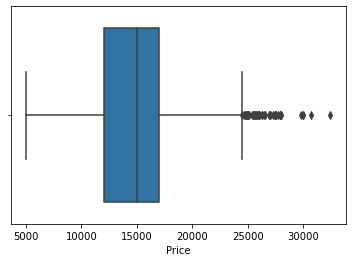

In [7]:
#Estadísticas descriptivas y boxplot de variable objetivo para conclusiones
print(data['Price'].describe())
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=data['Price'])
plt.show()

En primer lugar se definen las funciones a utilizar para la aplicación del árbol: las características de los nodos, el cálculo del MAE de apoyo para la mejor división,la mejor división, crecimiento recursivo del árbol,una función para calcular las predicciones y finalmente las funciones de cálculo del RMSE y el MAE para evaluar el modelo en el set de test.
### Los resultados:
la evaluacion del modelo con RMSE, indica que en promedio las predicciones del modelo se desvían 1701.19 del valor real del precio del auto.La evaluación del MAE, indica que en promedio las predicciones se desvian 1269.06. La metrica MAE es mas confiable en presencia de datos atípicos, como es el caso de la variable precio. No obstante, ambas métricas pueden indicar un buen desempeño del modelo, ya que los valores de desviacion son relativamente bajos al comparar con los datos de los precios de los automóviles, por medio de las estadísticas descriptivas como la media, la mediana o el percentil 75. El resultado de la métrica MAE se comparará más adelante con los de los otros modelos en el punto 8.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Celda 2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Inicializa una lista para almacenar los arboles individuales
arboles = []
n_arboles = 10
n_muestras = X_train.shape[0]

# Crea 10 arboles de regresion
for i in range(n_arboles):
    # Muestra con reemplazo de X_train e y_train
    indices = np.random.choice(range(n_muestras), size=n_muestras, replace=True)
    X_train_muestrado = X_train.iloc[indices]
    y_train_muestrado = y_train.iloc[indices]
    
    # Ajusta el arbol de regresion
    arbol = DecisionTreeRegressor()
    arbol.fit(X_train_muestrado, y_train_muestrado)
    
    # Almacena el arbol en la lista
    arboles.append(arbol)

# Función de predicción para el ensemble de bagging
def predecir_bagging(X):
    # Realiza predicciones con todos los arboles
    predicciones = np.array([arbol.predict(X) for arbol in arboles])
    
    # Promedia las predicciones para obtener la predicción final para cada muestra
    return np.mean(predicciones, axis=0)

# Evaluar el desempeño del modelo
y_pred = predecir_bagging(X_test)

# Calculo del Error Absoluto Medio (MAE)
mae_bagging_manual = mean_absolute_error(y_test, y_pred)
print(f'Error Absoluto Medio: {mae_bagging_manual}')

# Cálculo del coeficiente de determinación (R²)
r2_bagging_manual = r2_score(y_test, y_pred)
print(f'Coeficiente de determinación (R²): {r2_bagging_manual}')

Error Absoluto Medio: 1339.5750400032994
Coeficiente de determinación (R²): 0.7920224973764591


### Análisis Descriptivo para la Validación del Desempeño del Modelo

count     7031.000000
mean     14508.073389
std       3927.667432
min       5002.000000
25%      11998.000000
50%      15000.000000
75%      16996.000000
max      32444.000000
Name: Price, dtype: float64


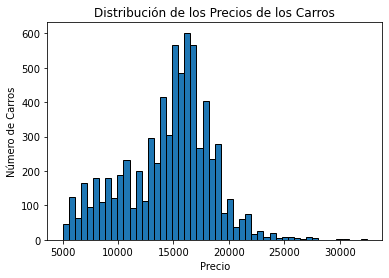

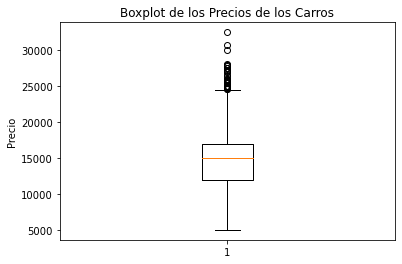

In [9]:
import matplotlib.pyplot as plt

# Estadísticas descriptivas de los precios de los carros
precios_descripcion = y_train.describe()
print(precios_descripcion)

# Crear un histograma para visualizar la distribución de los precios de los carros
plt.hist(y_train, bins=50, edgecolor='black')
plt.title('Distribución de los Precios de los Carros')
plt.xlabel('Precio') 
plt.ylabel('Número de Carros')
plt.show()

# Crear un boxplot para visualizar la distribución de los precios de los carros
plt.boxplot(y_train)
plt.title('Boxplot de los Precios de los Carros')  
plt.ylabel('Precio')  
plt.show()  

In [10]:
#  Calculo del porcentaje del MAE con respecto al precio promedio de los autos
MAE = 1334.22
media_precos = 14508.07

# Porcentaje del MAE con respecto a la media
porcentagem_MAE = (MAE / media_precos) * 100
porcentagem_MAE

9.196398969676876

#### Desempeño del Modelo

El modelo de bagging se utiliza de 10 árboles de regresión. El proceso consiste en generar subconjuntos del conjunto de entrenamiento a través de muestreo con reemplazo y entrenar un árbol de regresión independiente en cada uno de estos subconjuntos. Las predicciones del modelo de bagging se obtienen luego por la media de las predicciones de todos los árboles individuales, lo que ayuda a reducir la varianza y mejorar la robustez del modelo en comparación con un único árbol de decisión.

En cuanto al rendimiento, el Error Absoluto Medio (MAE) del modelo es de 1334,22, representando aproximadamente el 9,2% del precio medio de los coches, que es de 14508,07. Este valor del MAE indica que el modelo tiene una precisión razonable en la mayoría de los casos. Además, el coeficiente de determinación R² es de 0,789, lo que significa que aproximadamente el 78,9% de la variabilidad en los precios de los coches es explicada por el modelo. Este valor de R² indica que el modelo tiene una buena capacidad predictiva.

En resumen, el modelo de bagging manual muestra un rendimiento adecuado según el MAE y el R², sugiriendo que las predicciones promedio están relativamente cercanas a los valores reales y que el modelo explica una buena parte de la variabilidad en los datos. Estos indicadores sugieren que el modelo de bagging es una opción viable para la regresión en este contexto.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular el número de características para el parámetro max_features
n_features = X_train.shape[1]
max_features = int(np.log2(n_features))

# Crear el modelo de bagging con 10 árboles de decisión
bagging_model = BaggingRegressor(
    n_estimators=10,
    max_features=max_features,  # Especificar max_features como el logaritmo en base 2 del número de características
    bootstrap=True,
    oob_score=True,
    random_state=0
)

# Entrenar el modelo con los datos de entrenamiento
bagging_model.fit(X_train, y_train)

# Evaluar el modelo con los datos de prueba
y_pred = bagging_model.predict(X_test)

# Calcular métricas de desempeño
mae_bagging_lib = mean_absolute_error(y_test, y_pred)
# Cálculo del coeficiente de determinación (R²)
r2_bagging_lib = r2_score(y_test, y_pred)

print(f'Error Absoluto Medio (MAE): {mae_bagging_lib}')
print(f'Coeficiente de determinación (R²): {r2_bagging_lib}')

Error Absoluto Medio (MAE): 1551.5024909228398
Coeficiente de determinación (R²): 0.7364858447908116


#### Desempeño del Modelo

La métrica de Error Absoluto Medio (MAE) del modelo es de 1551.50, lo que implica que, aunque existe una desviación media en las predicciones, estas mantienen una precisión aceptable. Dado el amplio rango de precios en el mercado de automóviles, un MAE de esta magnitud puede ser interpretado como una señal de que el modelo es práctico y puede servir como una herramienta confiable.

Además el modelo alcanza un R² de 0.7365, lo que sugiere que captura con éxito una gran parte de la variabilidad de los datos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Inicializando el modelo de Random Forest
modelo_rf = RandomForestRegressor()

# Entrenando el modelo
modelo_rf.fit(X_train, y_train)

# Predeciendo los precios en el conjunto de prueba
y_modelo_rf = modelo_rf.predict(X_test)

# Calculando el MAE en el conjunto de prueba
mae_rf = mean_absolute_error(y_test, y_modelo_rf)
print("Error Absoluto Medio (MAE) en el conjunto de prueba:", mae_rf)

# Calculando el Coeficiente de Determinación en el conjunto de prueba
r2_rf = r2_score(y_test, y_modelo_rf)
print("Coeficiente de Determinación (R^2) en el conjunto de prueba:", r2_rf)


Error Absoluto Medio (MAE) en el conjunto de prueba: 1312.7086809549508
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.7964015917816529


##### Analisis del punto 4

El MAE del modelo de Random Forest es aproximadamente 1313.35. Esto significa que, en promedio, las predicciones del modelo están a $1313.35 de distancia del precio real de los vehículos en el conjunto de prueba.

El coeficiente de determinación del modelo de Random Forest es aproximadamente 0.7967. Esto indica que alrededor del 79.67% de la variabilidad en los precios de los vehículos se puede explicar utilizando las características proporcionadas al modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [35]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
modelo_rf_base = RandomForestRegressor()
# Definir la cuadrícula de parámetros a explorar
param_grid_rf = {
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [50, 100, 200, 300]}

# Inicializar GridSearchCV
grid_search_rf = GridSearchCV(estimator=modelo_rf_base, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)
# Obtener los mejores parámetros encontrados
print("Mejores parámetros:", grid_search_rf.best_params_)


Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}


In [36]:
# Obtener el mejor estimador (modelo)
modelo_optimo_rf = grid_search_rf.best_estimator_
# Realizar predicciones en el conjunto de prueba con el modelo optimizado
y_modelo_rf_optimo = modelo_optimo_rf.predict(X_test)

# Calculando el MAE en el conjunto de prueba
mae_rf_optimo = mean_absolute_error(y_test, y_modelo_rf_optimo)
print("Error Absoluto Medio (MAE) en el conjunto de prueba:", mae_rf_optimo)

# Calculando el Coeficiente de Determinación en el conjunto de prueba
r2_rf_optimo = r2_score(y_test, y_modelo_rf_optimo)
print("Coeficiente de Determinación (R^2) en el conjunto de prueba:", r2_rf_optimo)


Error Absoluto Medio (MAE) en el conjunto de prueba: 1147.023368691615
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.8400536406447436


##### Análisis del modelo de Random Forest calibrado
Algunas conclusiones del desempeño del modelo calibrado son:

* El MAE del modelo calibrado (1145.44) es menor que el MAE del modelo original (1313.35). Esto indica que, en promedio, las predicciones del modelo calibrado están más cerca de los valores reales que las del modelo original. Por lo tanto, el modelo calibrado tiene un mejor desempeño en términos de precisión de las predicciones.

* El R^2 del modelo calibrado (0.8402) es mayor que el R^2 del modelo original (0.7967). Esto indica que el modelo calibrado explica una mayor proporción de la variabilidad en los precios de los vehículos que el modelo original.

**¿Cómo cada parámetro afecta el desempeño del modelo?**

* max_depth (profundidad máxima): Este parámetro controla la profundidad máxima de cada árbol en el bosque. Un valor más alto puede permitir que los árboles sean más profundos y capturan más complejidad en los datos, pero también pueden aumentar el riesgo de sobreajuste. En este caso, el valor óptimo encontrado fue de 10, lo que sugiere que una profundidad moderada fue preferida para este conjunto de datos.

* max_features (máximo de características): Este parámetro controla el número máximo de características que se consideran para dividir un nodo en cada árbol. Utilizar un subconjunto de características puede ayudar a reducir la correlación entre árboles y el sobreajuste. En este caso, el valor óptimo encontrado fue 'sqrt', lo que indica que se utilizó la raíz cuadrada del número total de características como máximo de características.

* n_estimators (número de estimadores): Este parámetro representa el número de árboles en el bosque. Un mayor número de árboles generalmente conduce a un modelo más robusto y estable, pero también puede aumentar el tiempo de entrenamiento. En este caso, el valor óptimo encontrado fue de 300, lo que sugiere que se prefirió un número relativamente alto de árboles para este conjunto de datos.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [15]:
# Celda 6
# Importación y definición de modelo XGBoost, es regressor porque es un modelo de prediccion de precioxm2
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Inicializando el modelo XGBoost
modelo_xgboost = XGBRegressor()

# Entrenando el modelo
modelo_xgboost.fit(X_train, y_train)

# Predeciendo los precios en el conjunto de prueba
y_modelo_xgboost = modelo_xgboost.predict(X_test)

# Calculando el MAE en el conjunto de prueba
mae_xgboost = mean_absolute_error(y_test, y_modelo_xgboost)
print("Error Absoluto Medio (MAE) en el conjunto de prueba:", mae_xgboost)

# Calculando el Coeficiente de Determinación en el conjunto de prueba
r2_xgboost = r2_score(y_test, y_modelo_xgboost)
print("Coeficiente de Determinación (R^2) en el conjunto de prueba:", r2_xgboost)

Error Absoluto Medio (MAE) en el conjunto de prueba: 1185.2272991506386
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.8315404997841507


#### Analisis del punto6

Algunos conclusiones del desempeño del modelo, son:
* El MAE es aproximadamente 1185.23, esto significa que, en promedio, las predicciones del modelo XGBoost están a $1185.23 de distancia del precio real de los vehículos en el conjunto de prueba.
* El R2 es aproximandamente 0.8315, esto significa que alrededor del 83.15% de la variabilidad en los precios de los vehículos se puede explicar utilizando las características proporcionadas al modelo XGBoost.

Dado que el MAE es relativamente bajo y el R2 es relativamente alto, podemos decir que el modelo XGBoost tiene un buen desempeño en este caso.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [16]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
modelo_base = XGBRegressor()
# Definir la cuadrícula de parámetros a explorar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]}

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=modelo_base, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)
# Obtener los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05}


In [33]:
# Obtener el mejor estimador (modelo)
modelo_optimo_xgboost = grid_search.best_estimator_
# Realizar predicciones en el conjunto de prueba con el modelo optimizado
y_modelo_xgboost2 = modelo_optimo_xgboost.predict(X_test)

# Calculando el MAE en el conjunto de prueba
mae_xgboost2 = mean_absolute_error(y_test, y_modelo_xgboost2)
print("Error Absoluto Medio (MAE) en el conjunto de prueba:", mae_xgboost2)

# Calculando el Coeficiente de Determinación en el conjunto de prueba
r2_xgboost2 = r2_score(y_test, y_modelo_xgboost2)
print("Coeficiente de Determinación (R^2) en el conjunto de prueba:", r2_xgboost2)

Error Absoluto Medio (MAE) en el conjunto de prueba: 1134.6437124203865
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.8439447142295721


#### Analisis del punto7

Algunos conclusiones del desempeño del modelo, son:
* El MAE del modelo calibrado (1134.64) es menor que el MAE del modelo original (1185.23),esto significa que, en promedio, las predicciones del modelo calibrado están más cerca de los valores reales que las del modelo original.
Por lo tanto, el modelo calibrado tiene un mejor desempeño en términos de precisión de las predicciones.
* El R2 del modelo calibrado (0.8439) es mayor que el R2 del modelo original (0.8315),esto indica que el modelo calibrado explica una mayor proporción de la variabilidad en los precios de los vehículos que el modelo original.

En resumen, la calibración del modelo XGBoost con los mejores parámetros ha mejorado tanto la precisión de las predicciones (MAE más bajo) como la capacidad del modelo para explicar la variabilidad en los datos (mayor R2).

**¿Cómo cada parámetro afecta el desempeño del modelo?**
* learning_rate(tasa de aprendizaje):La tasa de aprendizaje controla la magnitud con la que los pesos de los árboles de decisión se actualizan durante el proceso de entrenamiento.En este caso, el valor óptimo encontrado fue de 0.05, lo que sugiere que una tasa de aprendizaje más baja fue preferida para este conjunto de datos.

* Gamma:Es un parámetro de regularización que controla la complejidad del modelo mediante la reducción del crecimiento de los árboles.En este caso, el valor óptimo encontrado fue de 0.1, lo que sugiere que una regularización
moderada fue preferida para este conjunto de datos.

* colsample_bytree: Es la fracción de características que se utilizará para entrenar cada árbol individual.En este caso, el valor óptimo encontrado fue de 0.7, lo que sugiere que utilizar un subconjunto moderado de características fue preferido para este conjunto de datos.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

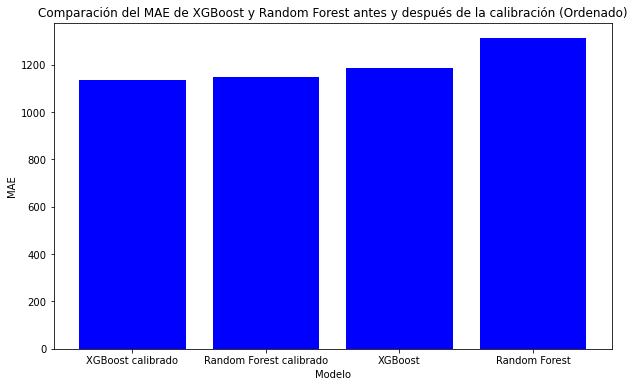

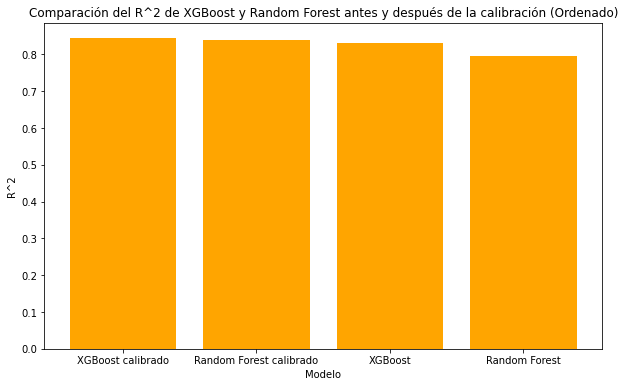

In [37]:
# Celda 8
# Comparando métricas de los modelos
mae_values = [mae_xgboost, mae_xgboost2, mae_rf, mae_rf_optimo]
r2_values = [r2_xgboost, r2_xgboost2, r2_rf, r2_rf_optimo]
model_names = ['XGBoost', 'XGBoost calibrado', 'Random Forest', 'Random Forest calibrado']

# Ordenando métricas por MAE
sorted_models_mae = [model_name for _, model_name in sorted(zip(mae_values, model_names))]
sorted_mae_values = sorted(mae_values)

# Ordenando métricas por R^2
sorted_models_r2 = [model_name for _, model_name in sorted(zip(r2_values, model_names), reverse=True)]
sorted_r2_values = sorted(r2_values, reverse=True)

# Creando el histograma del MAE
plt.figure(figsize=(10, 6))
plt.bar(sorted_models_mae, sorted_mae_values, color='blue')
plt.title('Comparación del MAE de XGBoost y Random Forest antes y después de la calibración (Ordenado)')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.show()

# Creando el histograma del R^2
plt.figure(figsize=(10, 6))
plt.bar(sorted_models_r2, sorted_r2_values, color='orange')
plt.title('Comparación del R^2 de XGBoost y Random Forest antes y después de la calibración (Ordenado)')
plt.xlabel('Modelo')
plt.ylabel('R^2')
plt.show()
